# Aiguto - GI health tracker.
На рынке есть ряд трекеров для гастроэнтерологического здоровья. Часть из них даже предоставяет ряд платных телемедецинских услуг. Но всех их объединяет одно - диагностировать стул должен сам пациент. 
Согласно исследованию (https://onlinelibrary.wiley.com/doi/full/10.1111/apt.13746) большинство пациентов не точно диагностирует состояние своего стула по бристольской шкале, да и зачем им собственно этим заниматься, если есть AI. 

В компании Aiguto мы создаём трекер, который не будет требовать заносить данные текстом, только фотографии и кнопки.

**Поставленная передо мной задача - проверить возможность классификации стула по бристолькской шкале стула и развернуть это в бэкэнде на AWS через автоматически масштабируемые AWS lambda функции.** 

Ноутбук, который перед вами - содержит в себе обучение нейронной сети которая уже развернуна в MVP нашего приложения. Датасет был собран в поисковиках и на паре не очень здоровых, но очень для нас полезных subreddit_ах. Разметку делал лаборант с многолетним опытом. В ручную разделён примрно 80 обучающая выборка и 20 валидационная. Для простоты разложено по папкам заранее. 

*   В качестве MVP было решено группировать данные по 3м простым подгруппам, поскольку на 1000 фотографий 7ми классов не удавалось выжать из модели accuracy больше 79 процентов. 
*  Когда будут новые размеченные данные, можно будет попробовать обучать более легкие сети. Что будет экономить деньги на бэкэнд. Но прототип надо сделать быстро, и развернуть его через легко масштабируемые мощности.  
*  Мы в первую очередь проверяли возможность этого предприятия , поскольку в доступном нам на тот момент исследовании результат на реальных данных достигнут не был см (https://arxiv.org/ftp/arxiv/papers/1903/1903.10578.pdf) (стр 7) (сеть переобучалась до состояния , когда все результаты были класса 1 , что давало максимальную точность на реальных данных) 
*  На данном этапе важно создать максимально работающую модель где сonfusion matrix покажет нам значения отличные от наиболее распростанённого класса и будет срабатывать хотябы в половине случаев на более редких классах (0 и 2) 



In [1]:
!pip install tensorflow

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
!pip install efficientnet


     |████████████████████████████████| 50 kB 1.3 MB/s eta 0:00:011
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [3]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf

import tensorflow
import tensorflow.keras.models as M
import tensorflow.keras.layers as L
from tensorflow.keras import backend as K
import tensorflow.keras.callbacks as C
from tensorflow.keras.callbacks import Callback 

from keras.preprocessing.image import ImageDataGenerator

import efficientnet as efn

%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import cv2  # for image processing
import scipy.io
import os
import tarfile

In [4]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [5]:
# В сетап выношу основные настройки, так удобней их перебирать в дальнейшем

EPOCHS               = 15
BATCH_SIZE           = 4
LR                   = 1e-3
VAL_SPLIT            = 0.2
RANDOM_SEED          = 42
CLASS_NUM            = 3
IMG_SIZE             = 456
IMG_CHANNELS         = 3
input_shape          = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)

train_PATH = '../input/var2/train'
test_PATH = "../input/var2/test"

In [6]:
train_datagen=ImageDataGenerator(rescale=1./255,
                                 rotation_range = 50,
                                 shear_range=0.2,
                                 zoom_range=[0.75,1.25],
                                 brightness_range=[0.5, 1.5],
                                 width_shift_range=0.1,
                                 height_shift_range=0.1,
                                 horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1. / 255)

In [7]:

train = train_datagen.flow_from_directory('../input/var2/train', 
                                          target_size=(IMG_SIZE, IMG_SIZE),
                                          color_mode='rgb',
                                          classes=None,
                                          class_mode='categorical',
                                          batch_size=BATCH_SIZE,
                                          shuffle=True,
                                          seed=RANDOM_SEED,
                                          subset=None,
                                          interpolation='nearest')

test=test_datagen.flow_from_directory('../input/var2/test',
                                     target_size=(IMG_SIZE, IMG_SIZE),
                                     color_mode='rgb',
                                     classes=None,
                                     class_mode='categorical',
                                     batch_size=BATCH_SIZE,
                                     shuffle=False,
                                     seed=RANDOM_SEED,
                                     subset=None,
                                     interpolation='nearest')


Found 746 images belonging to 3 classes.
Found 185 images belonging to 3 classes.


**Проверяем, что агументации не слишком поменяли фотографии и объекты узнаваемы.** 

Пример картинок из train_generator


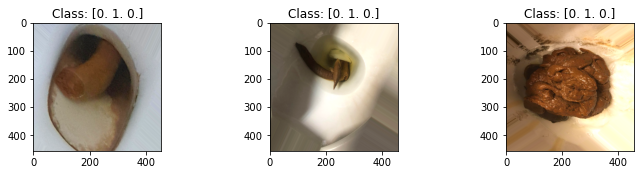

In [8]:
from skimage import io

def imshow(image_RGB):
    io.imshow(image_RGB)
    io.show()
    
x,y = train.next()
print('Пример картинок из train_generator')
plt.figure(figsize=(12,8))

for i in range(0,3):
    image = x[i]
    plt.subplot(3,3, i+1)
    plt.imshow(image)
    plt.title('Class: '+str(y[i]))
    #plt.axis('off')
plt.show()


Пример картинок из test_generator


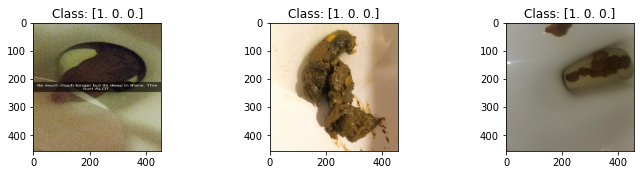

In [10]:
x,y = test.next()
print('Пример картинок из test_generator')
plt.figure(figsize=(12,8))

for i in range(0,3):
    image = x[i]
    plt.subplot(3,3, i+1)
    plt.imshow(image)
    plt.title('Class: '+str(y[i]))
    #plt.axis('off')
plt.show()

**Создаём функцию для визуализации обучения**

In [9]:
def plot_history(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
# summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [11]:
input_shape

(456, 456, 3)

In [12]:

from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

Загружаем и переобучаем модель EfficientNetB7. 65миллионов параметров ) 245 мегабайт скопилированной модели. 


In [13]:
import efficientnet.tfkeras as efn

In [14]:
base_model = efn.EfficientNetB7(weights='imagenet', include_top=False, input_shape=input_shape)

258441216/258434480 [==============================] - 4s 0us/step


In [15]:
base_model.summary()

Model: "efficientnet-b7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 456, 456, 3) 0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 228, 228, 64) 1728        input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 228, 228, 64) 256         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 228, 228, 64) 0           stem_bn[0][0]                    
____________________________________________________________________________________

__________________________________________________________________________________________________
block6e_drop (FixedDropout)     (None, 15, 15, 384)  0           block6e_project_bn[0][0]         
__________________________________________________________________________________________________
block6e_add (Add)               (None, 15, 15, 384)  0           block6e_drop[0][0]               
                                                                 block6d_add[0][0]                
__________________________________________________________________________________________________
block6f_expand_conv (Conv2D)    (None, 15, 15, 2304) 884736      block6e_add[0][0]                
__________________________________________________________________________________________________
block6f_expand_bn (BatchNormali (None, 15, 15, 2304) 9216        block6f_expand_conv[0][0]        
__________________________________________________________________________________________________
block6f_ex

In [16]:
base_model.trainable = False

In [17]:
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

**Новая голова простая но даёт небольшой прирост в точности, чем просто пулинг и софтмакс**

In [18]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x=(BatchNormalization())(x)
# let's add a fully-connected layer
x = Dense(256, activation='elu')(x)
x=(BatchNormalization())(x)
x = Dropout(0.25)(x)
# and a logistic layer -- let's say we have 3 classes
predictions = Dense(CLASS_NUM, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

In [19]:
len(model.trainable_variables)

8

In [20]:
from tensorflow.keras import optimizers

In [21]:
LR=0.001
model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(lr=LR), metrics=["accuracy"])

**Настройка чекпоинтов экономит время и если не спасает от переобучения , то сокращает его.** 

In [22]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [23]:
checkpoint = ModelCheckpoint('best_model.hdf5' , monitor = ['val_accuracy'] , verbose = 1  , mode = 'max')
earlystop = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)
callbacks_list = [checkpoint, earlystop]

In [24]:
scores = model.evaluate_generator(test, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

47/47 [==============================] - 6s 137ms/step - loss: 1.1245 - accuracy: 0.2865
Accuracy: 28.65%


In [25]:
history = model.fit_generator(
                    train,
                    steps_per_epoch = train.samples//train.batch_size,
                    validation_data = test, 
                    validation_steps = test.samples//test.batch_size,
                    epochs = 100,#25
                    callbacks = callbacks_list
                    )

Epoch 1/100
186/186 [==============================] - ETA: 0s - loss: 1.1555 - accuracy: 0.5323
Epoch 00001: saving model to best_model.hdf5
186/186 [==============================] - 76s 406ms/step - loss: 1.1555 - accuracy: 0.5323 - val_loss: 0.6221 - val_accuracy: 0.7717
Epoch 2/100
186/186 [==============================] - ETA: 0s - loss: 0.9812 - accuracy: 0.6388
Epoch 00002: saving model to best_model.hdf5
186/186 [==============================] - 73s 393ms/step - loss: 0.9812 - accuracy: 0.6388 - val_loss: 0.5977 - val_accuracy: 0.7554
Epoch 3/100
186/186 [==============================] - ETA: 0s - loss: 0.8187 - accuracy: 0.6900
Epoch 00003: saving model to best_model.hdf5
186/186 [==============================] - 73s 393ms/step - loss: 0.8187 - accuracy: 0.6900 - val_loss: 0.6161 - val_accuracy: 0.7663
Epoch 4/100
186/186 [==============================] - ETA: 0s - loss: 0.8123 - accuracy: 0.7008
Epoch 00004: saving model to best_model.hdf5
186/186 [=====================

Epoch 31/100
186/186 [==============================] - ETA: 0s - loss: 0.6092 - accuracy: 0.7601
Epoch 00031: saving model to best_model.hdf5
186/186 [==============================] - 74s 396ms/step - loss: 0.6092 - accuracy: 0.7601 - val_loss: 0.4820 - val_accuracy: 0.7880
Epoch 32/100
186/186 [==============================] - ETA: 0s - loss: 0.6176 - accuracy: 0.7547
Epoch 00032: saving model to best_model.hdf5
186/186 [==============================] - 75s 401ms/step - loss: 0.6176 - accuracy: 0.7547 - val_loss: 0.4274 - val_accuracy: 0.8261
Epoch 33/100
186/186 [==============================] - ETA: 0s - loss: 0.6532 - accuracy: 0.7399
Epoch 00033: saving model to best_model.hdf5
186/186 [==============================] - 74s 400ms/step - loss: 0.6532 - accuracy: 0.7399 - val_loss: 0.4482 - val_accuracy: 0.8641
Epoch 34/100
186/186 [==============================] - ETA: 0s - loss: 0.6202 - accuracy: 0.7547
Epoch 00034: saving model to best_model.hdf5
186/186 [=================

In [26]:
model.save('../working/model_step1.hdf5')
model.load_weights('best_model.hdf5')

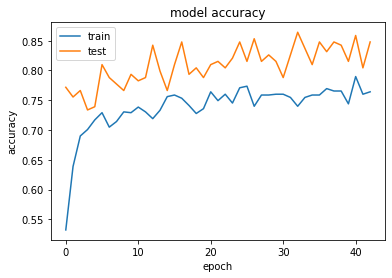

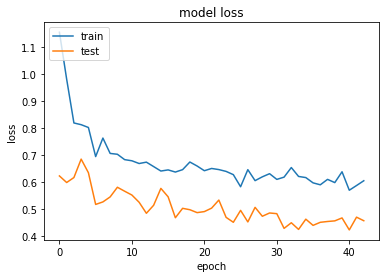

In [27]:
plot_history(history)

In [28]:
scores = model.evaluate_generator(test, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

47/47 [==============================] - 6s 134ms/step - loss: 0.4582 - accuracy: 0.8432
Accuracy: 84.32%


In [29]:
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  806


In [30]:
base_model.trainable = True

# Fine-tune from this layer onwards
fine_tune_at = len(base_model.layers)//2

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

In [31]:
len(base_model.trainable_variables)

354

In [32]:
# Check the trainable status of the individual layers
for layer in model.layers:
    print(layer, layer.trainable)

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f4284c14510> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f4284224b90> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7f42841d1810> False
<tensorflow.python.keras.layers.core.Activation object at 0x7f429c282ad0> False
<tensorflow.python.keras.layers.convolutional.DepthwiseConv2D object at 0x7f4284198f50> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7f42841bfb50> False
<tensorflow.python.keras.layers.core.Activation object at 0x7f4284112a50> False
<tensorflow.python.keras.layers.pooling.GlobalAveragePooling2D object at 0x7f428411fa10> False
<tensorflow.python.keras.layers.core.Reshape object at 0x7f428411ff90> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f4284300790> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f4284146b50> False
<tensorflow.python.keras.layers.

<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f3e40694c50> False
<tensorflow.python.keras.layers.merge.Multiply object at 0x7f3e40699f50> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f3e4069fdd0> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7f3e406aa910> False
<efficientnet.model.get_dropout.<locals>.FixedDropout object at 0x7f3e406ae150> False
<tensorflow.python.keras.layers.merge.Add object at 0x7f3e406ae310> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f3e406ae7d0> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7f3e4065f810> False
<tensorflow.python.keras.layers.core.Activation object at 0x7f3e406620d0> False
<tensorflow.python.keras.layers.convolutional.DepthwiseConv2D object at 0x7f3e40662750> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7f3e4066a690> False
<tensorflow.python.keras.layers.

<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f3e401ca290> True
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7f3e401f5b90> True
<tensorflow.python.keras.layers.core.Activation object at 0x7f3e401fb810> True
<tensorflow.python.keras.layers.convolutional.DepthwiseConv2D object at 0x7f3e401fbd10> True
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7f3e40180290> True
<tensorflow.python.keras.layers.core.Activation object at 0x7f3e401a27d0> True
<tensorflow.python.keras.layers.pooling.GlobalAveragePooling2D object at 0x7f3e401ad790> True
<tensorflow.python.keras.layers.core.Reshape object at 0x7f3e401a2510> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f3e401a8350> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f3e40147e50> True
<tensorflow.python.keras.layers.merge.Multiply object at 0x7f3e4014cb10> True
<tensorflow.python.keras.layers.convolutional.Conv2

In [33]:
LR=0.0001
model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(lr=LR), metrics=["accuracy"])

In [34]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 456, 456, 3) 0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 228, 228, 64) 1728        input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 228, 228, 64) 256         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 228, 228, 64) 0           stem_bn[0][0]                    
_______________________________________________________________________________________

block2b_expand_conv (Conv2D)    (None, 114, 114, 288 13824       block2a_project_bn[0][0]         
__________________________________________________________________________________________________
block2b_expand_bn (BatchNormali (None, 114, 114, 288 1152        block2b_expand_conv[0][0]        
__________________________________________________________________________________________________
block2b_expand_activation (Acti (None, 114, 114, 288 0           block2b_expand_bn[0][0]          
__________________________________________________________________________________________________
block2b_dwconv (DepthwiseConv2D (None, 114, 114, 288 2592        block2b_expand_activation[0][0]  
__________________________________________________________________________________________________
block2b_bn (BatchNormalization) (None, 114, 114, 288 1152        block2b_dwconv[0][0]             
__________________________________________________________________________________________________
block2b_ac

__________________________________________________________________________________________________
block2g_se_squeeze (GlobalAvera (None, 288)          0           block2g_activation[0][0]         
__________________________________________________________________________________________________
block2g_se_reshape (Reshape)    (None, 1, 1, 288)    0           block2g_se_squeeze[0][0]         
__________________________________________________________________________________________________
block2g_se_reduce (Conv2D)      (None, 1, 1, 12)     3468        block2g_se_reshape[0][0]         
__________________________________________________________________________________________________
block2g_se_expand (Conv2D)      (None, 1, 1, 288)    3744        block2g_se_reduce[0][0]          
__________________________________________________________________________________________________
block2g_se_excite (Multiply)    (None, 114, 114, 288 0           block2g_activation[0][0]         
          

block5i_se_reshape (Reshape)    (None, 1, 1, 1344)   0           block5i_se_squeeze[0][0]         
__________________________________________________________________________________________________
block5i_se_reduce (Conv2D)      (None, 1, 1, 56)     75320       block5i_se_reshape[0][0]         
__________________________________________________________________________________________________
block5i_se_expand (Conv2D)      (None, 1, 1, 1344)   76608       block5i_se_reduce[0][0]          
__________________________________________________________________________________________________
block5i_se_excite (Multiply)    (None, 29, 29, 1344) 0           block5i_activation[0][0]         
                                                                 block5i_se_expand[0][0]          
__________________________________________________________________________________________________
block5i_project_conv (Conv2D)   (None, 29, 29, 224)  301056      block5i_se_excite[0][0]          
__________

block6d_drop (FixedDropout)     (None, 15, 15, 384)  0           block6d_project_bn[0][0]         
__________________________________________________________________________________________________
block6d_add (Add)               (None, 15, 15, 384)  0           block6d_drop[0][0]               
                                                                 block6c_add[0][0]                
__________________________________________________________________________________________________
block6e_expand_conv (Conv2D)    (None, 15, 15, 2304) 884736      block6d_add[0][0]                
__________________________________________________________________________________________________
block6e_expand_bn (BatchNormali (None, 15, 15, 2304) 9216        block6e_expand_conv[0][0]        
__________________________________________________________________________________________________
block6e_expand_activation (Acti (None, 15, 15, 2304) 0           block6e_expand_bn[0][0]          
__________

In [35]:
len(base_model.trainable_variables)

354

In [36]:
scores = model.evaluate_generator(test, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

47/47 [==============================] - 6s 133ms/step - loss: 0.4582 - accuracy: 0.8432
Accuracy: 84.32%


In [37]:
history = model.fit_generator(
                    train,
                    steps_per_epoch = train.samples//train.batch_size,
                    validation_data = test, 
                    validation_steps = test.samples//test.batch_size,
                    epochs = 100,#25
                    callbacks = callbacks_list
                    )

Epoch 1/100
186/186 [==============================] - ETA: 0s - loss: 0.7801 - accuracy: 0.6995
Epoch 00001: saving model to best_model.hdf5
186/186 [==============================] - 90s 485ms/step - loss: 0.7801 - accuracy: 0.6995 - val_loss: 0.4170 - val_accuracy: 0.8424
Epoch 2/100
186/186 [==============================] - ETA: 0s - loss: 0.6799 - accuracy: 0.7372
Epoch 00002: saving model to best_model.hdf5
186/186 [==============================] - 91s 488ms/step - loss: 0.6799 - accuracy: 0.7372 - val_loss: 0.3850 - val_accuracy: 0.8641
Epoch 3/100
186/186 [==============================] - ETA: 0s - loss: 0.6337 - accuracy: 0.7601
Epoch 00003: saving model to best_model.hdf5
186/186 [==============================] - 90s 484ms/step - loss: 0.6337 - accuracy: 0.7601 - val_loss: 0.3402 - val_accuracy: 0.9022
Epoch 4/100
186/186 [==============================] - ETA: 0s - loss: 0.5955 - accuracy: 0.7763
Epoch 00004: saving model to best_model.hdf5
186/186 [=====================

In [38]:
model.save('../working/model_step2.hdf5')
model.load_weights('best_model.hdf5')

In [39]:
scores = model.evaluate_generator(test,steps=40, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

40/40 [==============================] - 5s 135ms/step - loss: 0.2402 - accuracy: 0.8938
Accuracy: 89.38%


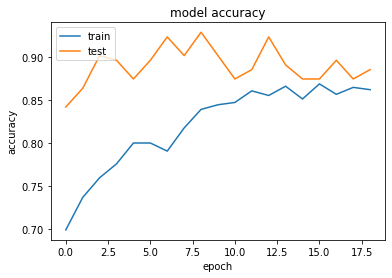

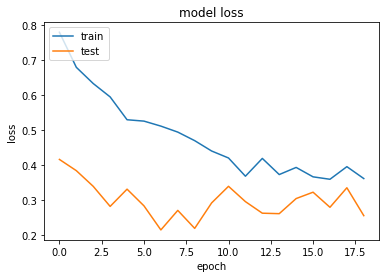

In [40]:
plot_history(history)

In [41]:
test1=test_datagen.flow_from_directory('../input/var2/test',
                                     target_size=(IMG_SIZE, IMG_SIZE),
                                     color_mode='rgb',
                                     classes=None,
                                     class_mode='categorical',
                                    
                                     shuffle=False,
                                     seed=RANDOM_SEED,
                                     subset=None,
                                     interpolation='nearest')


Found 185 images belonging to 3 classes.


In [42]:
fun= model.predict(test1)
y_classes = fun.argmax(axis=-1)


In [43]:
import sklearn.metrics as mt
mt.confusion_matrix( test1.labels, y_classes)

array([[ 14,   8,   0],
       [  5, 125,   3],
       [  0,   5,  25]])

In [44]:
base_model.trainable = True
LR=0.00001
model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adamax(lr=LR), metrics=["accuracy"])

In [45]:
history = model.fit_generator(
                    train,
                    steps_per_epoch = train.samples//train.batch_size,
                    validation_data = test, 
                    validation_steps = test.samples//test.batch_size,
                    epochs = 100,#25
                    callbacks = callbacks_list
                    )

Epoch 1/100
186/186 [==============================] - ETA: 0s - loss: 0.3629 - accuracy: 0.8625
Epoch 00001: saving model to best_model.hdf5
186/186 [==============================] - 153s 820ms/step - loss: 0.3629 - accuracy: 0.8625 - val_loss: 0.2600 - val_accuracy: 0.9022
Epoch 2/100
186/186 [==============================] - ETA: 0s - loss: 0.4085 - accuracy: 0.8329
Epoch 00002: saving model to best_model.hdf5
186/186 [==============================] - 148s 797ms/step - loss: 0.4085 - accuracy: 0.8329 - val_loss: 0.3227 - val_accuracy: 0.8967
Epoch 3/100
186/186 [==============================] - ETA: 0s - loss: 0.4072 - accuracy: 0.8504
Epoch 00003: saving model to best_model.hdf5
186/186 [==============================] - 147s 790ms/step - loss: 0.4072 - accuracy: 0.8504 - val_loss: 0.3137 - val_accuracy: 0.8913
Epoch 4/100
186/186 [==============================] - ETA: 0s - loss: 0.4657 - accuracy: 0.8140
Epoch 00004: saving model to best_model.hdf5
186/186 [==================

In [46]:
model.save('../working/model_step3.hdf5')
model.load_weights('best_model.hdf5')

In [47]:
scores = model.evaluate_generator(test, steps=40, verbose=1)
#predition= model.predict_generator(test,steps=2, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

40/40 [==============================] - 5s 137ms/step - loss: 0.2895 - accuracy: 0.9000
Accuracy: 90.00%


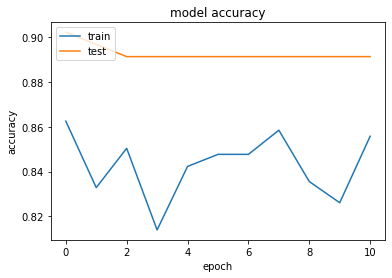

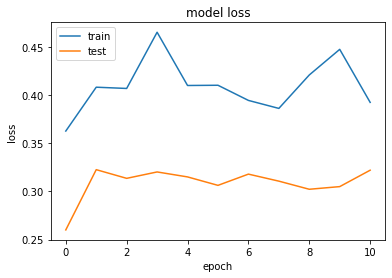

In [48]:
plot_history(history)

In [49]:
test.labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2], dtype=int32)

In [50]:
fun= model.predict(test1)
y_classes = fun.argmax(axis=-1)

Если взглянуть на confusion_matrix то видно , что ошибка третьего порядка уже не происходит ( понос с запором уже не путает) , а большую часть редких классов интерпретирует правильно. Так что для MVP эта модель вполне сойдёт. Несмотря на то, что она несколько переобучена и может хуже работать на реальных данных. 

In [51]:
mt.confusion_matrix( test1.labels, y_classes)

array([[ 17,   5,   0],
       [  8, 123,   2],
       [  0,   6,  24]])

**А тут у нас небольшое забегание вперёд - в деплой модели в AWS Lambda с использованием весьма ужатого tensorflow, что позволяет существенно экономить время исполнения. Пользоваться тут мы будем TF Lite - набором для развораяивания сетей в мобильных приложениях. Там по сути нет ничего лишнего, просто исполнение графа вычислений.** 

In [52]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
open("converted_model.tflite", "wb").write(tflite_model)

257465820